# Volume-Price Linear Regression

### Goal: Using linear regression, predict the ensuing day's closing value for any high-volume S&P500 stock. The independent variables are volume-weighted returns over 8 standard time horizons as well as the previous day's closing price. The motivation for using volume-weighted returns comes from the book Volume Price Analysis, where Anna Coulling suggests that volume can be used to validate or invalidate price action.

In [49]:
import numpy as np
import pandas as pd
from pandas_datareader import data
from datetime import datetime
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#### Create S&P500 Tickers List

In [50]:
df = pd.read_csv('/Users/cullenbaker/Downloads/ticks.csv')
tickers = df['Symbol'].tolist()
tickers[0:10]

['AAPL', 'ABBV', 'ABT', 'ACN', 'AGN', 'AIG', 'ALL', 'AMGN', 'AMZN', 'AXP']

#### Import stock data from IEX

In [51]:
start_date = datetime(2015, 1, 1)
end_date = datetime(2019, 1, 1)

stock_data = data.DataReader(tickers, 'iex', start_date, end_date)

#### Refine dataset

In [52]:
stock_data = stock_data.loc[:, ['close', 'volume']]
stock_data.head()

Attributes     close                                                         \
Symbols         AAPL     ABBV      ABT      ACN       AGN      AIG      ALL   
date                                                                          
2015-01-02  101.5280  55.5960  40.8010  81.3950  250.1029  51.2722  64.7362   
2015-01-05   98.6678  54.5497  40.8101  80.0207  247.7479  50.2579  63.4530   
2015-01-06   98.6771  54.2797  40.3466  79.4435  246.2808  49.5452  63.4068   
2015-01-07  100.0607  56.4735  40.6738  81.1110  255.9904  49.7828  64.4500   
2015-01-08  103.9053  57.0642  41.5098  82.3478  259.5905  49.5635  65.6871   

Attributes                                ...         volume             \
Symbols         AMGN    AMZN      AXP     ...            TXN        UNH   
date                                      ...                             
2015-01-02  143.2089  308.52  86.6383     ...      4026075.0  3070081.0   
2015-01-05  141.5071  302.19  84.3470     ...      5599324.0  4684055.0   
2015-01-06  136.9481  295.29  82.5495     ...      5468393.0  3468294.0   
2015-01-07  141.7310  298.42  84.3524     ...      4577116.0  3225790.0   
2015-01-08  141.2205  300.46  85.5481     ...      6295206.0  5346136.0   

Attributes                                                           \
Symbols           UNP        UPS         USB        UTX           V   
date                                                                  
2015-01-02  3084363.0  2667996.0   5011005.0  3143341.0   8394080.0   
2015-01-05  4608447.0  3522224.0   6568724.0  4765317.0  12751200.0   
2015-01-06  6323925.0  3814551.0   8529685.0  5772347.0  11070492.0   
2015-01-07  4008375.0  1949531.0   5073711.0  3102192.0   9346840.0   
2015-01-08  4851031.0  2879051.0  10417592.0  3899898.0  10443656.0   

Attributes                                     
Symbols             VZ        WBA         WFC  
date                                           
2015-01-02  11421233.0  3938482.0  11700856.0  
2015-01-05  18964458.0  4771744.0  15000528.0  
2015-01-06  22950060.0  4882715.0  20211187.0  
2015-01-07  20793637.0  5672058.0  15714655.0  
2015-01-08  17617453.0  4087169.0  16721579.0  

[5 rows x 196 columns]

#### Further refine by setting a minimum average daily volume requirement

In [53]:
volume = stock_data['volume']
volume.mean().head()

Symbols
AAPL    3.786395e+07
ABBV    7.895292e+06
ABT     6.946152e+06
ACN     2.355334e+06
AGN     3.227234e+06
dtype: float64

In [54]:
Hvolume = volume.loc[:, volume.mean() > 5000000]
symlist = Hvolume.columns
newcols = [('close', sym) for sym in symlist] + [('volume', sym) for sym in symlist]

HiVol = stock_data.loc[:, newcols]
HiVol.shape 

(1006, 112)

In [55]:
dates = HiVol.index
HiVol = HiVol.set_index(dates)

#### Create the desired independent variables from the dataset. Particularly, we want the volume weighted returns for 1-day, 2-day, 3-day, week, month, 3-month, 6-month, and year intervals. First we calculate average log returns, then we multiply this figure by average volume (in millions) over the corresponding period

In [56]:
D_log_ret = np.log(HiVol.loc[:, 'close']/HiVol.loc[:, 'close'].shift(1))
D2_log_ret = np.log(HiVol.loc[:, 'close']/HiVol.loc[:, 'close'].shift(2))/2
D3_log_ret = np.log(HiVol.loc[:, 'close']/HiVol.loc[:, 'close'].shift(3))/3
W_log_ret = np.log(HiVol.loc[:, 'close']/HiVol.loc[:, 'close'].shift(5))/5
M_log_ret = np.log(HiVol.loc[:, 'close']/HiVol.loc[:, 'close'].shift(21))/21
M3_log_ret = np.log(HiVol.loc[:, 'close']/HiVol.loc[:, 'close'].shift(63))/63
M6_log_ret = np.log(HiVol.loc[:, 'close']/HiVol.loc[:, 'close'].shift(126))/126
Y_log_ret = np.log(HiVol.loc[:, 'close']/HiVol.loc[:, 'close'].shift(252))/252

In [57]:
D_Avg_Vol = HiVol.loc[:, 'volume']/1000000
D2_Avg_Vol = HiVol.loc[:, 'volume'].rolling(window=2).mean()/1000000
D3_Avg_Vol = HiVol.loc[:, 'volume'].rolling(window=3).mean()/1000000
W_Avg_Vol = HiVol.loc[:, 'volume'].rolling(window=5).mean()/1000000
M_Avg_Vol = HiVol.loc[:, 'volume'].rolling(window=21).mean()/1000000
M3_Avg_Vol = HiVol.loc[:, 'volume'].rolling(window=63).mean()/1000000
M6_Avg_Vol = HiVol.loc[:, 'volume'].rolling(window=126).mean()/1000000
Y_Avg_Vol = HiVol.loc[:, 'volume'].rolling(window=252).mean()/1000000

In [58]:
D_VolWeightRet = D_Avg_Vol*D_log_ret
D2_VolWeightRet = D2_Avg_Vol*D2_log_ret
D3_VolWeightRet = D3_Avg_Vol*D3_log_ret
W_VolWeightRet = W_Avg_Vol*W_log_ret
M_VolWeightRet = M_Avg_Vol*M_log_ret
M3_VolWeightRet = M3_Avg_Vol*M3_log_ret
M6_VolWeightRet = M6_Avg_Vol*M6_log_ret
Y_VolWeightRet = Y_Avg_Vol*Y_log_ret

#### Organize the data into a format that is conducive for success when implementing the linear regression algorithm

In [59]:
ticker = 'AAPL'
data_len = D_VolWeightRet[ticker].shape[0]
B0 = np.ones(data_len)
B1 = HiVol.loc[:, 'close'][ticker]
var_list = pd.DataFrame({ 'B0' : B0, 'B1' : B1, 'B2' : D_VolWeightRet[ticker], 
                    'B3' : D2_VolWeightRet[ticker], 'B4' : D3_VolWeightRet[ticker], 
                    'B5' : W_VolWeightRet[ticker], 'B6' : M_VolWeightRet[ticker], 
                    'B7' : M3_VolWeightRet[ticker], 'B8' : M6_VolWeightRet[ticker], 
                    'B9' : Y_VolWeightRet[ticker],})

var_list.head(10)

,B0,B1,B2,B3,B4,B5,B6,B7,B8,B9
date,,,,,,,,,,
2015-01-02,1.0,101.5280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,1.0,98.6678,-1.837020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,1.0,98.6771,0.006201,-0.926244,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,1.0,100.0607,0.558439,0.371146,-0.275282,NaN,NaN,NaN,NaN,NaN
2015-01-08,1.0,103.9053,2.238216,1.283841,0.949761,NaN,NaN,NaN,NaN,NaN
2015-01-09,1.0,104.0167,0.057542,1.096000,0.896871,0.274379,NaN,NaN,NaN,NaN
2015-01-12,1.0,101.4537,-1.238734,-0.616933,0.249958,0.299175,NaN,NaN,NaN,NaN
2015-01-13,1.0,102.3545,0.593075,-0.470158,-0.284783,0.395038,NaN,NaN,NaN,NaN
2015-01-14,1.0,101.9645,-0.186895,0.145704,-0.366872,0.210162,NaN,NaN,NaN,NaN


#### Refine independent variable data to the usuable dataset

In [60]:
var_list1 = var_list[252:-1]
var_list1.head()

,B0,B1,B2,B3,B4,B5,B6,B7,B8,B9
date,,,,,,,,,,
2016-01-04,1.0,99.4989,0.057816,-0.502831,-0.470761,-0.192339,-0.206387,-0.029172,-0.071201,-0.004159
2016-01-05,1.0,97.0055,-1.415915,-0.756821,-0.801784,-0.346061,-0.243640,-0.049203,-0.080894,-0.003498
2016-01-06,1.0,95.1072,-1.352923,-1.402202,-0.944292,-0.792786,-0.359083,-0.066592,-0.078734,-0.007588
2016-01-07,1.0,91.0932,-3.496915,-2.351124,-2.013807,-1.340880,-0.460779,-0.094382,-0.088209,-0.019396
2016-01-08,1.0,91.5749,0.373393,-1.437186,-1.410495,-1.129485,-0.464322,-0.082764,-0.097202,-0.026117


#### Create the price target values for supervised learning

In [61]:
price_target = HiVol.loc[:, 'close'][ticker][253:]
price_target.head()

date
2016-01-05    97.0055
2016-01-06    95.1072
2016-01-07    91.0932
2016-01-08    91.5749
2016-01-11    93.0577
Name: AAPL, dtype: float64

#### Randomly sort the training and test data. 

In [62]:
X_train, X_test, y_train, y_test = train_test_split(var_list1, 
                                    price_target, test_size=0.2, random_state=0)

In [63]:
train_stats = X_train.describe().transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
B0,602.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
B1,602.0,144.355118,39.340505,86.307900,106.163550,146.487600,171.667750,230.275400
B2,602.0,-0.013192,0.835158,-9.064426,-0.155891,0.013918,0.217776,6.628790
B3,602.0,-0.003292,0.592736,-4.707754,-0.114653,0.020474,0.165130,3.460759
B4,602.0,0.003627,0.463631,-3.161684,-0.109161,0.018994,0.144498,2.702390
B5,602.0,0.005358,0.319925,-1.703840,-0.094013,0.031900,0.132646,1.689961
B6,602.0,0.005881,0.142925,-0.496911,-0.039279,0.030424,0.102026,0.296493
B7,602.0,0.018107,0.067603,-0.261141,0.001269,0.030979,0.060428,0.121200
B8,602.0,0.020775,0.041581,-0.124583,0.011971,0.029826,0.049702,0.082361
B9,602.0,0.016771,0.034194,-0.065174,-0.005883,0.029643,0.043634,0.071380


#### Normalize the independent variables to enhance probability of model convergence

In [64]:
def norm(x):
    return (x - train_stats['mean']) / (train_stats['std'] + 0.00000000001)
normed_train_data = norm(X_train)
normed_test_data = norm(X_test)

normed_train_data.head()

,B0,B1,B2,B3,B4,B5,B6,B7,B8,B9
date,,,,,,,,,,
2016-09-21,0.0,-0.896926,0.008208,-0.002298,-0.345644,0.552279,0.612483,1.266594,0.069000,-0.381261
2017-05-31,0.0,0.111378,-0.158086,-0.098772,-0.123211,-0.105788,0.405898,0.269546,1.162787,1.107002
2017-01-03,0.0,-0.818884,0.113847,-0.119178,-0.101240,-0.061936,0.521391,0.010348,0.871955,0.040885
2016-05-23,0.0,-1.327614,0.590630,0.696785,0.463787,0.618114,-1.454814,-0.047137,-2.140541,-2.153906
2018-01-29,0.0,0.518900,-1.252424,-0.698054,-1.159396,-1.426661,-0.195453,0.201098,0.169531,0.576552


#### Fit the model. Then calculate R^2. The closer to 1, the better the accuracy of the trained model on the test data

In [65]:
model = LinearRegression()
model.fit(normed_train_data, y_train)
model.score(normed_test_data, y_test)

0.995743170404882

#### Calculate the coeficients of the independent variables

In [66]:
model.coef_

array([ 0.00000000e+00,  3.90772141e+01,  2.33177780e-01,  3.68979476e-03,
       -3.39546497e-01,  2.29006516e-01,  8.10389562e-02, -9.70591874e-02,
       -1.40983863e-01,  2.82475001e-01])

#### Create a dataframe showing the predicted values, the corresponding actual values, and the difference between them. Then output the average percentage error of the model on the test data

In [67]:
analy = pd.DataFrame({ 'Predicted' : model.predict(normed_test_data), 
                      'Actual' : y_test,
                      'Difference' : y_test - model.predict(normed_test_data)})
analy['Difference'].apply(lambda x: abs(x)).mean()/analy['Actual'].mean()*100

1.0711175144902556

#### Plot the predictions against the actuals

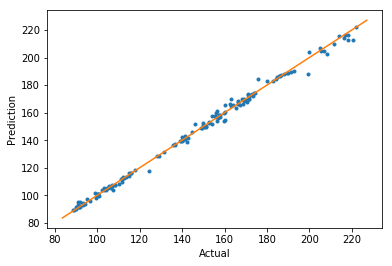

In [68]:
y_pred = model.predict(normed_test_data)
plt.plot(y_test, y_pred, '.')

x = np.linspace(min(y_test)-5, max(y_test)+5, 5)
y = x
plt.plot(x, y)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

#### Create a histogram of the dollar-amount errors between the predictions and actuals using test data

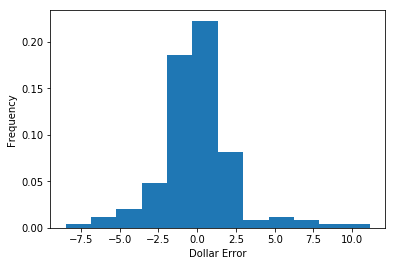

In [69]:
n_bins = 12
x = analy['Difference']

fig, ax = plt.subplots()
ax.hist(x, bins=n_bins, density=True)
plt.xlabel('Dollar Error')
plt.ylabel('Frequency')
plt.show()